# Showcase functions of MPPData class
TODO add some comments, add code showing concatenation

In [110]:
import importlib
import sys
sys.path.append('..')

import miann.data._data
from miann.data._data import MPPData
importlib.reload(miann.data._data)

from miann.utils import init_logging
import os
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)
#init_logging()

In [111]:
mpp_data = miann.data._data.MPPData.from_data_dir('184A1_unperturbed/I09', data_config='NascentRNA')
print(mpp_data)

INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].


In [46]:
# filter by NO_NAN cellcycle stage
mpp_data.subset(cell_cycle='NO_NAN')
print(np.unique(mpp_data.metadata.cell_cycle))

INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to NO_NAN cell_cycle: 557 objects


['G1' 'G2' 'S']


In [47]:
# add conditions
cond_params = {}
mpp_data.add_conditions(['TR_norm_lowhigh_bin_2', 'TR_bin_3', 'cell_cycle'], cond_params=cond_params)

print(mpp_data.conditions)
print(cond_params)

INFO:MPPData:Adding conditions: ['TR_norm_lowhigh_bin_2', 'TR_bin_3', 'cell_cycle']
INFO:MPPData:Looking up condition TR_norm, with postprocess lowhigh_bin_2
INFO:MPPData:Looking up condition TR, with postprocess bin_3
INFO:MPPData:Looking up condition cell_cycle, with postprocess None
INFO:convert_condition:Converting condition cell_cycle to numbers


[[ 0.  1.  0.  0.  1.  2.]
 [ 0.  1.  0.  0.  1.  2.]
 [ 0.  1.  0.  0.  1.  2.]
 ...
 [nan nan  0.  1.  0.  1.]
 [nan nan  0.  1.  0.  1.]
 [nan nan  0.  1.  0.  1.]]
{'TR_norm_lowhigh_bin_2_quantile': [342.17970793352254, 423.8084316974745], 'TR_bin_3_quantile': [362.1374296178866, 411.146330758427]}


In [48]:
# filter nan objects with nan conditions
mpp_data.subset(nona_condition=True)

INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to objects with NO_NAN condition: 283


In [83]:
# normalise
rescale_values = []
mpp_data.normalise(background_value='mean_background', percentile= 98.0, rescale_values=rescale_values)
print(rescale_values)

INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channel with 98.0 percentile


[706.0, 55.889077674895006, 69.29248486934, 292.580564999614, 97.797795010537, 49.969012700825004, 198.166104554605, 103.192703487811, 333.88636174276803, 99.989850032596, 113.921074631886, 217.454320872445, 274.374678140131, 189.10488029550498, 562.873113168236, 172.093431062583, 80.143769097638, 197.20852422806, 209.926705230017, 420.026212072665, 482.722105769381, 153.451838886362, 225.390029544676, 88.901763855899, 463.498049074523, 155.04311273660198, 172.21535973943702, 622.34514056733, 139.20844135918, 704.734122587939, 233.365936479147, 25.306330100778, 199.97347517141299, 76.3, 329.3]


In [95]:
# subsample
mpp_data_sub = mpp_data.subsample(frac_per_obj=0.05, 
add_neighborhood=True, neighborhood_size=3)

print(mpp_data.mpp.shape, mpp_data_sub.mpp.shape)

INFO:MPPData:Subsampling each object to 5.0%
INFO:MPPData:Created new: MPPData for NascentRNA (606235 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'mpp', 'obj_ids', 'labels'].
INFO:MPPData:Adding neighborhood of size 3


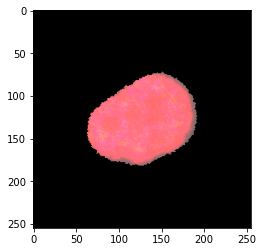

In [103]:
# get and plot image
import matplotlib.pyplot as plt

img = mpp_data.get_object_img(mpp_data.unique_obj_ids[0], 
channel_ids=[0,1,10], img_size=255)

plt.imshow(img)

In [112]:
# subset channels
mpp_data.subset_channels(['00_EU', '15_SON'])
print(mpp_data.channels)

INFO:MPPData:Restricted channels to 2 channels


Int64Index([0, 22], dtype='int64')    index    name
0      0   00_EU
1     22  15_SON
